In [9]:
import numpy as np
import pickle
import networkx as nx
import netgraph
import matplotlib.pylab as plt
import os
from tqdm import tqdm

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler

from Qommunity.iterative_searcher.iterative_searcher import IterativeSearcher

os.makedirs("./Reults_Adversarial-examples", exist_ok=True)

In [66]:
def plot_network_in_communities(graph, comms, filename=None, community_to_color=None, hub_size=False, node_labels=False, ax=None):
  # Determine node size based on eigenvector centrality
  if hub_size==False:
    eigen_centrality = 1
  else:
    eigen_centrality = {node: hub_size*eigen for node, eigen in nx.eigenvector_centrality(graph).items()}
  directed = nx.is_directed(graph)

  # Organize nodes and colors
  node_to_community = dict()
  for community_id, c in enumerate(comms):
      for node in c:
          node_to_community[node] = community_id
  if community_to_color==None:
    community_to_color = np.random.rand(community_id+1,3)
  node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()} 

  # Edge widths
  edge_width = {}
  for (u,v,w) in graph.edges(data=True):
     if "weight" in w.keys():
        edge_width[(u, v)] = w['weight'] * .75 if directed else w['weight'] * .25
     else:
        edge_width[(u, v)] = .75 if directed else .25

  # Plotting
  netgraph.Graph(graph,
        edge_alpha=1, node_color=node_color, 
        node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
        edge_color="black", node_edge_width=0.1, node_size=eigen_centrality,
        edge_width=edge_width, node_labels=node_labels, node_label_fontdict={"size": 10}, 
        arrows=True if directed else False, ax=ax
  )
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
    print("\nYour plot is saved to {}".format(filename))
  
def modularity_matrix(graph, resolution: float=1) -> np.ndarray:
    adj_matrix: np.ndarray = nx.to_numpy_array(graph)
    degree_matrix: np.ndarray = adj_matrix.sum(axis=1)
    m: int = np.sum(degree_matrix) # This is 2m in reality
    return (                       # np.outer already contains a 1/2 factor
        adj_matrix
        - resolution * np.outer(degree_matrix, degree_matrix) / m
    )

def generalized_modularity_matrix(graph, community, resolution: float=1) -> np.ndarray:
    community = list(community)
    # Modularity matrix computed on the full network
    full_B = modularity_matrix(graph,resolution)
    # Elements B_ij inside the community
    B_bis = full_B[community,:]
    B_community = B_bis[:,community]
    # Summation over nodes inside the community (i.e., right term)
    B_i = np.sum(B_community, axis=1)
    delta = np.eye(len(community), dtype=np.int32)
    # Generalized modularity matrix
    return B_community - delta*B_i

def dynamic_range(modularity_matrix, precision=6):
    N = len(modularity_matrix)
    B = np.triu(modularity_matrix, k=0).flatten()

    # Compute all pairwise differences
    try:
      diff_matrix = np.abs(B[:, None] - B[None, :]) # Uses numpy broadcasting
      triu_diffs = diff_matrix[np.triu_indices(len(B), k=1)]
      triu_diffs = np.round(triu_diffs, precision)
      nonzero_diffs = triu_diffs[triu_diffs != 0]

      if nonzero_diffs.size == 0:
          return 0

      Dmax, Dmin = nonzero_diffs.max(),nonzero_diffs.min()
    
    except:  # Exceeds memory capacity
      print("WARNING! Numpy broadcasting. Using explicit implementation.")
      D = []
      for i, x in enumerate(B):
          for y in B[i+1:]:
              d = np.round(np.abs(x-y), precision)
              if d!=0:
                D.append(d)
      Dmax, Dmin = max(D), min(D)
    
    DR = np.log2(Dmax / Dmin)

    d_precision = 10 ** (-precision)
    dDR = np.abs(((1 / Dmax) - (1 / Dmin)) * d_precision)
    if dDR == 0:
        decimals_to_show = precision
    else:
        decimals_to_show = int(-np.floor(np.log10(dDR)))# - 1
    
    return round(DR, decimals_to_show), round(dDR, decimals_to_show)

In [85]:
n, m, p = 100, 1, .1
num_runs_L = 100
num_runs = 20
try:
    K = pickle.load(open(f"./Reults_Adversarial-examples/Graph__Power-law_n-{n}_m-{m}_p-{p}_NLouv-{num_runs_L}_NAdv-{num_runs}.pickle", 'rb'))
    print("Network loaded")
except:
    K = nx.powerlaw_cluster_graph(n=n, m=m, p=p)

    pickle.dump(K, open(f"./Reults_Adversarial-examples/Graph__Power-law_n-{n}_m-{m}_p-{p}_NLouv-{num_runs_L}_NAdv-{num_runs}.pickle", 'wb'))
    print("Network saved")

# DON´T edit this cell to have the same pair of nodes
if n == 100:
    node_1, node_2 = 72, 38
elif n ==50:
    node_1, node_2 = 8, 25
else:
    node_1, node_2 = 4, 13

Network loaded


In [ ]:
#results = {}

# Dynamic range
weights_to_test = [1, 10, 50, 100, 500, 1000, 5000, 10000]
for weight_to_put in weights_to_test:

    # Add the weight
    K.add_edge(node_1, node_2, weight=weight_to_put)

    # Calculate the dynamic range of the qubo
    B = modularity_matrix(K, resolution=1)
    DR, DR_error = dynamic_range(B, precision=6)

    # Louvain
    louv_sampler = LouvainSampler(K, resolution=1)
    louv_iterative = IterativeSearcher(louv_sampler)
    cs_all, mod_all, ts_all = louv_iterative.run(num_runs=num_runs_L, save_results=False)
    louv_communities = cs_all[mod_all.argmax()]
    louv_modularity = mod_all.max()

    # Hierarchical annealing
    adv_sampler = AdvantageSampler(K, resolution=1, version="Advantage_system6.4", region="na-west-1")
    adv_iterative = IterativeSearcher(adv_sampler)
    cs_all, mod_all, ts_all = adv_iterative.run(num_runs=num_runs, save_results=False)
    adv_communities = cs_all[mod_all.argmax()]
    adv_modularity = mod_all.max()

    results[weight_to_put] = {"Louvain mod": louv_modularity, "Annealing mod": adv_modularity, "Louvain Comms": louv_communities, "Advantage Comms": adv_communities, "Dynamic range": DR}
    print("Done: ", weight_to_put)
    np.save(f"./Reults_Adversarial-examples/Power-law_n-{n}_m-{m}_p-{p}_NLouv-100_NAdv-{num_runs}__w-{weight_to_put}.npy", results[weight_to_put], allow_pickle=True)
    break

# Save
#np.save(f"./Reults_Adversarial-examples/Power-law_n-{n}_m-{m}_p-{p}_NLouv-100_NAdv-{num_runs}.npy", results, allow_pickle=True)

In [91]:
np.save("./Reults_Adversarial-examples/Power-law_n-20_m-1_p-0.1_NLouv-100_NAdv-20.npy", results_n20, allow_pickle=True)
np.save("./Reults_Adversarial-examples/Power-law_n-50_m-1_p-0.1_NLouv-100_NAdv-20.npy", results_n50, allow_pickle=True)
np.save("./Reults_Adversarial-examples/Power-law_n-100_m-1_p-0.1_NLouv-100_NAdv-20.npy", results_n100, allow_pickle=True)

In [92]:
K20 = pickle.load(open("./Reults_Adversarial-examples/Graph__Power-law_n-20_m-1_p-0.1_NLouv-100_NAdv-20.pickle", 'rb'))
results_n20 = np.load("./Reults_Adversarial-examples/Power-law_n-20_m-1_p-0.1_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]

K50 = pickle.load(open("./Reults_Adversarial-examples/Graph__Power-law_n-50_m-1_p-0.1_NLouv-100_NAdv-20.pickle", 'rb'))
results_n50 = np.load("./Reults_Adversarial-examples/Power-law_n-50_m-1_p-0.1_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]

K100 = pickle.load(open("./Reults_Adversarial-examples/Graph__Power-law_n-100_m-1_p-0.1_NLouv-100_NAdv-20.pickle", 'rb'))
results_n100 = np.load("./Reults_Adversarial-examples/Power-law_n-100_m-1_p-0.1_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]

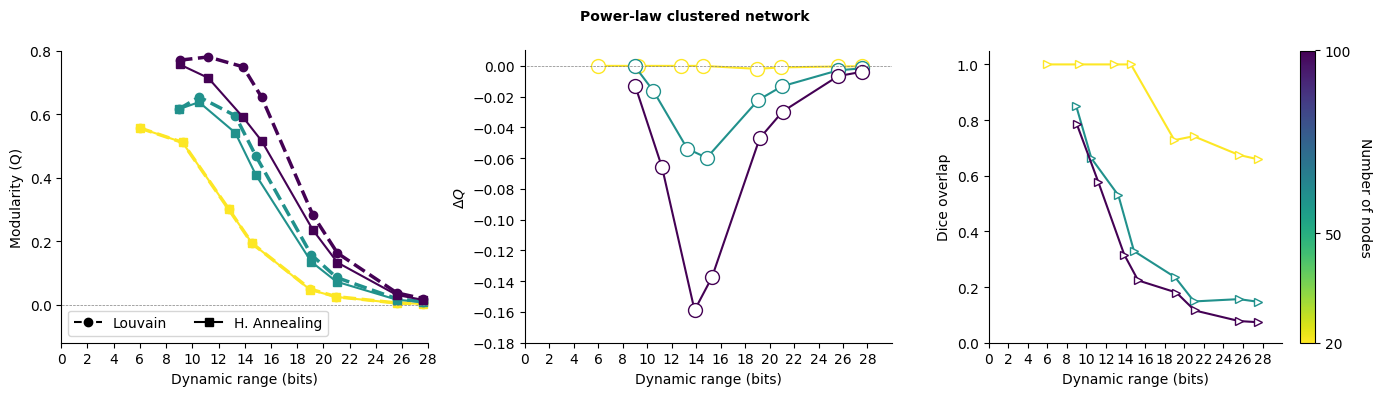

In [93]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))

network_sizes = [20, 50, 100]
colors = ["#fde725", "#21918c", "#440154"]  # viridis-like colors
results_dict = [results_n20, results_n50, results_n100]
dices = []
for i, (n, color, results) in enumerate(zip(network_sizes, colors, results_dict)):
    ax.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Louvain mod"] for k,v in results.items()],
        '--o',
        color=color,
        linewidth=2.5,
        label="Louvain" if i == 0 else ""
    )
    ax.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Annealing mod"] for k,v in results.items()],
        '-s',
        color=color,
        linewidth=1.5,
        label="H. Annealing" if i == 0 else ""
    )

    dices.append(np.empty(shape=(len(results.keys()), ), dtype=object))
    for j, (_, w) in enumerate(results.items()):
        dices[i][j] = np.zeros((len(w["Louvain Comms"]), len(w["Advantage Comms"])))
        for ii, c_leid in enumerate(w["Louvain Comms"]):
            for jj, c_adv in enumerate(w["Advantage Comms"]):                
                # Dice score
                intersection = set(c_leid).intersection(set(c_adv))
                dice = 2*len(intersection) / (len(set(c_leid))+len(set(c_adv)))
                dices[i][j][ii,jj] = np.where(dice==0, np.nan, dice)
    
    ax2.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Annealing mod"]-v["Louvain mod"] for k,v in results.items()],
        '-o',
        color=color,
        markerfacecolor="white",
        linewidth=1.5,
        markersize=10
    )

    ax3.plot(
        [v["Dynamic range"] for k,v in results.items()],
        [np.nanmean(dc) for dc in dices[i]],
        '->',
        color=color,
        markerfacecolor="white",
        linewidth=1.5,
        label=f"6 3-cliques (N={6*3})"
    )

ax.plot([-5,30], [0,0], linestyle='--', linewidth=.5, color='gray')
ax.spines[["top","right"]].set_visible(False)
ax.set_ylim([-0.12,0.8])
ax.set_yticks([0,.2,.4,.6,.8])
ax.set_xlim([0,28])
ax.set_xticks(range(0,30,2))
ax.set_xlabel("Dynamic range (bits)")
ax.set_ylabel("Modularity (Q)")

ax2.plot([-5,30], [0,0], linestyle='--', linewidth=.5, color='gray')
ax2.spines[["top","right"]].set_visible(False)
ax2.set_ylim([-0.18,0.01])
ax2.set_yticks(np.arange(-.18,0.02,.02))
ax2.set_xlim([0,30])
ax2.set_xticks(range(0,30,2))
ax2.set_xlabel("Dynamic range (bits)")
ax2.set_ylabel(r'$\Delta Q$')

ax3.plot([-5,30], [0,0], linestyle='--', linewidth=.5, color='gray')
ax3.spines[["top","right"]].set_visible(False)
ax3.set_ylim([0,1.05])
ax3.set_yticks([0,.2,.4,.6,.8,1])
ax3.set_xlim([0,30])
ax3.set_xticks(range(0,30,2))
ax3.set_xlabel("Dynamic range (bits)")
ax3.set_ylabel("Dice overlap")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], linestyle='--', marker='o', color='black', linewidth=1.5, label='Louvain'),
    Line2D([0], [0], linestyle='-', marker='s', color='black', linewidth=1.5, label='H. Annealing')
]
ax.legend(handles=legend_elements, ncols=2, loc="lower left")

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=20, vmax=100))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3)
cbar.set_label('Number of nodes', rotation=270, labelpad=15)
cbar.set_ticks([20, 50, 100])

fig.suptitle("Power-law clustered network", fontsize=10, fontweight="bold")
fig.tight_layout()
fig.savefig(f"./Reults_Adversarial-examples/power-law_dynamic-range.svg", format='svg', dpi=300)

### 3-Cliques

In [96]:
def generate_clique(directed=False):
  if directed:
    G = nx.DiGraph()
  else:
    G = nx.Graph()
  G.add_edges_from([(0,1),(1,2),(0,2)])
  c = [0,1,2]
  A_ij = nx.to_numpy_array(G, nodelist=c)
  return A_ij, np.array(c)

def join_cliques(cliques, directed=False):
  A = np.zeros((3*len(cliques),3*len(cliques)))
  for i, cl in enumerate(cliques):
    A[3*i:3*(i+1),3*i:3*(i+1)] = cl
  for i in range(len(cliques)-1):
      A[3*i,3*(i+1)] = 1
      if not directed:
        A[3*(i+1),3*i] = 1
  A[0,-3] = 1
  if not directed:
    A[-3,0] = 1
  return A

def generate_clique_chain(N, directed=False):
    cls = []
    clique_comms = []
    for i in range(N):
        cl, c = generate_clique(directed=directed)
        cls.append(cl)
        clique_comms.append(set(c+3*i))
    A = join_cliques(cls, directed=directed)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph) if directed else  nx.from_numpy_array(A, create_using=nx.Graph)
    return A, G, clique_comms

In [ ]:
num_runs_L = 100
num_runs = 20

# Generating the chains
N_cliques = 2 # 2, 6, 20
_, G, clique_comms = generate_clique_chain(N_cliques, directed=False)

results_cl = {}

for weight_to_put_cl in [(1,1), (10,.1), (50,.05), (100,.001)]:

    # Add the weight
    G.add_edge(1, 2, weight=weight_to_put_cl[0])
    G.add_edge(4, 5, weight=weight_to_put_cl[1])

    # Calculate the dynamic range of the qubo
    B = modularity_matrix(G, resolution=1)
    DR, DR_error = dynamic_range(B, precision=6)

    # Louvain
    louv_sampler_cl = LouvainSampler(G, resolution=1)
    louv_iterative_cl = IterativeSearcher(louv_sampler_cl)
    cs_all_cl, mod_all_cl, _ = louv_iterative_cl.run(num_runs=num_runs_L, save_results=False)
    louv_communities_cl = cs_all_cl[mod_all_cl.argmax()]
    louv_modularity_cl = mod_all_cl.max()

    # Hierarchical annealing
    adv_sampler_cl = AdvantageSampler(G, resolution=1, version="Advantage_system6.4", region="na-west-1")
    adv_iterative_cl = IterativeSearcher(adv_sampler_cl)
    cs_all_cl, mod_all_cl, _ = adv_iterative_cl.run(num_runs=num_runs, save_results=False)
    adv_communities_cl = cs_all_cl[mod_all_cl.argmax()]
    adv_modularity_cl = mod_all_cl.max()

    results_cl[weight_to_put_cl] = {"Louvain mod": louv_modularity_cl, "Annealing mod": adv_modularity_cl, "Louvain Comms": louv_communities_cl, "Advantage Comms": adv_communities_cl, "Dynamic range": DR}

# Save
np.save(f"./Reults_Adversarial-examples/3clique-{N_cliques}_NLouv-100_NAdv-{num_runs}.npy", results_cl, allow_pickle=True)

In [114]:
results_N2 = np.load("./Reults_Adversarial-examples/3clique-2_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]
results_N6 = np.load("./Reults_Adversarial-examples/3clique-6_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]
results_N20 = np.load("./Reults_Adversarial-examples/3clique-20_NLouv-100_NAdv-20.npy", allow_pickle=True)[()]

In [115]:
dice_2 = np.empty(shape=(len(results_N2.keys()), ), dtype=object)
for i, (_, w) in enumerate(results_N2.items()):
    dice_2[i] = np.zeros((len(w["Louvain Comms"]), len(w["Advantage Comms"])))
    for ii, c_leid in enumerate(w["Louvain Comms"]):
        for jj, c_adv in enumerate(w["Advantage Comms"]):
            
            # Dice score
            intersection = set(c_leid).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_leid))+len(set(c_adv)))
            dice_2[i][ii,jj] = np.where(dice==0, np.nan, dice)

dice_6 = np.empty(shape=(len(results_N6.keys()), ), dtype=object)
for i, (_, w) in enumerate(results_N6.items()):
    dice_6[i] = np.zeros((len(w["Louvain Comms"]), len(w["Advantage Comms"])))
    for ii, c_leid in enumerate(w["Louvain Comms"]):
        for jj, c_adv in enumerate(w["Advantage Comms"]):
            
            # Dice score
            intersection = set(c_leid).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_leid))+len(set(c_adv)))
            dice_6[i][ii,jj] = np.where(dice==0, np.nan, dice)

dice_20 = np.empty(shape=(len(results_N20.keys()), ), dtype=object)
for i, (_, w) in enumerate(results_N20.items()):
    dice_20[i] = np.zeros((len(w["Louvain Comms"]), len(w["Advantage Comms"])))
    for ii, c_leid in enumerate(w["Louvain Comms"]):
        for jj, c_adv in enumerate(w["Advantage Comms"]):
            
            # Dice score
            intersection = set(c_leid).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_leid))+len(set(c_adv)))
            dice_20[i][ii,jj] = np.where(dice==0, np.nan, dice)

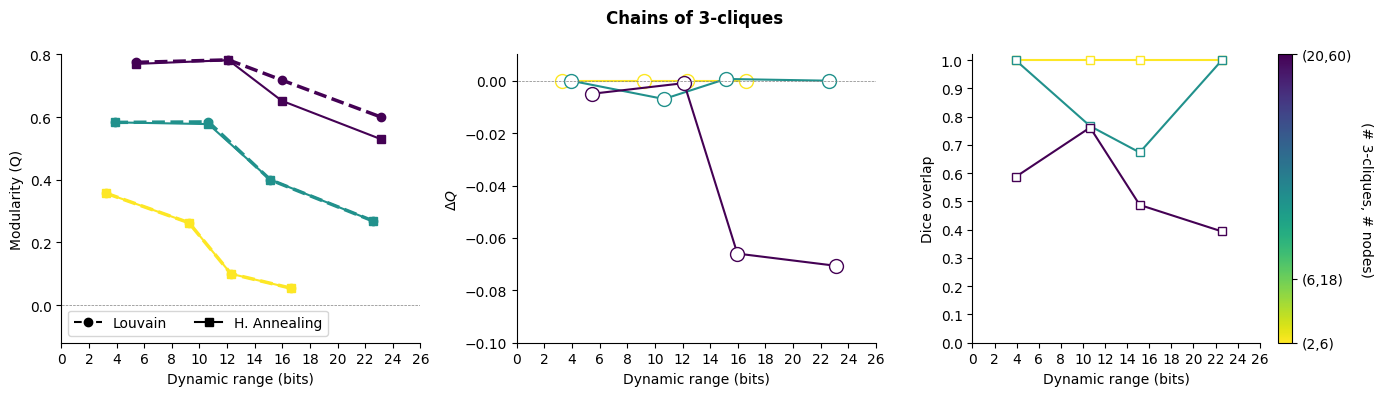

In [121]:
fig, (ax,ax2, ax3) = plt.subplots(1,3,figsize=(14,4))

network_sizes = [6,18,60]
colors = ["#fde725", "#21918c", "#440154"]  # viridis-like colors, "#21918c"
results_dict = [results_N2, results_N6, results_N20]
dices = [dice_2, dice_6, dice_20]
for i, (n, color, results) in enumerate(zip(network_sizes, colors, results_dict)):
    ax.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Louvain mod"] for k,v in results.items()],
        '--o',
        color=color,
        linewidth=2.5,
        label="Louvain" if i == 0 else ""
    )
    ax.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Annealing mod"] for k,v in results.items()],
        '-s',
        color=color,
        linewidth=1.5,
        label="H. Annealing" if i == 0 else ""
    )

    ax2.plot(
        [v["Dynamic range"] for k,v in results.items()], 
        [v["Annealing mod"]-v["Louvain mod"] for k,v in results.items()],
        '-o',
        color=color,
        markerfacecolor="white",
        linewidth=1.5,
        markersize=10
    )

    ax3.plot(
        [v["Dynamic range"] for k,v in results_N6.items()],
        [np.nanmean(dc) for dc in dices[i]],
        '-s',
        color=color,
        markerfacecolor="white",
        linewidth=1.5
    )

ax.plot([-5,30], [0,0], linestyle='--', linewidth=.5, color='gray')
ax.spines[["top","right"]].set_visible(False)
ax.set_ylim([-0.12,0.8])
ax.set_yticks([0,.2,.4,.6,.8])
ax.set_xlim([0,26])
ax.set_xticks(range(0,28,2))
ax.set_xlabel("Dynamic range (bits)")
ax.set_ylabel("Modularity (Q)")
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], linestyle='--', marker='o', color='black', linewidth=1.5, label='Louvain'),
    Line2D([0], [0], linestyle='-', marker='s', color='black', linewidth=1.5, label='H. Annealing')
]
ax.legend(handles=legend_elements, ncols=2, loc="lower left")

ax2.plot([-5,30], [0,0], linestyle='--', linewidth=.5, color='gray')
ax2.spines[["top","right"]].set_visible(False)
ax2.set_ylim([-0.1,0.01])
ax2.set_yticks(np.arange(-.1,.02,.02))
ax2.set_xlim([0,26])
ax2.set_xticks(range(0,28,2))
ax2.set_xlabel("Dynamic range (bits)")
ax2.set_ylabel(r'$\Delta Q$')

ax3.spines[["top","right"]].set_visible(False)
ax3.set_ylim([0.,1.02])
ax3.set_yticks(np.arange(0,1.1,.1))
ax3.set_xlim([0,26])
ax3.set_xticks(range(0,28,2))
ax3.set_xlabel("Dynamic range (bits)")
ax3.set_ylabel("Dice overlap")

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=6, vmax=60))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3)
cbar.set_label('(# 3-cliques, # nodes)', rotation=270, labelpad=15)
cbar.set_ticks([6,18,60])
cbar.set_ticklabels(["(2,6)","(6,18)","(20,60)"])

fig.suptitle("Chains of 3-cliques", fontweight="bold")
fig.tight_layout()
fig.savefig(f"./Reults_Adversarial-examples/chain-of-cliques.svg", format='svg', dpi=300)

### Chains of nodes --> No clear modular structure

In [ ]:
num_runs_L = 100
num_runs = 20

nodes = 80 # 15
CHAIN = nx.Graph()
for i in range(nodes):
    CHAIN.add_edge(i,i+1)
CHAIN.add_edge(0,nodes)


cs_all_ch, mod_all_ch, _ = IterativeSearcher(LouvainSampler(CHAIN, resolution=1)).run(num_runs=num_runs_L, save_results=False)
louv_communities_ch = cs_all_ch[mod_all_ch.argmax()]
louv_modularity_ch = mod_all_ch.max()

cs_all_ch, mod_all_ch, _ = IterativeSearcher(AdvantageSampler(CHAIN, resolution=1, version="Advantage_system6.4", region="na-west-1")).run(num_runs=num_runs, save_results=False)
adv_communities_ch = cs_all_ch[mod_all_ch.argmax()]
adv_modularity_ch = mod_all_ch.max()

print("Modularity with Louvain: ", louv_modularity_ch)
print("Modularity with Advantage: ", adv_modularity_ch)

100%|██████████| 20/20 [25:18<00:00, 75.92s/it]

Modularity with Louvain:  0.7771681146166742
Modularity with Advantage:  0.7761012040847431


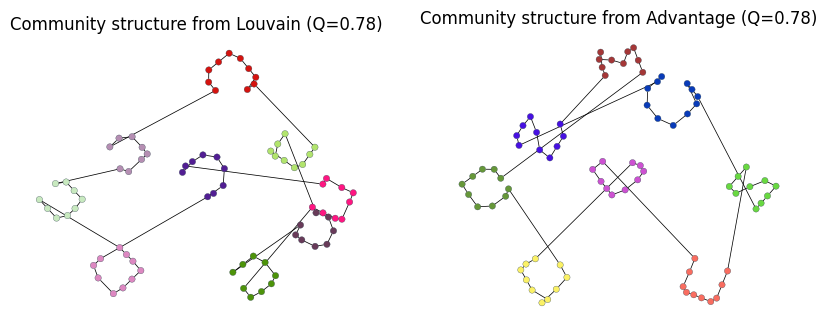

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_network_in_communities(CHAIN, louv_communities_ch, hub_size=10, ax=ax[0])
ax[0].set_title(f"Community structure from Louvain (Q={louv_modularity_ch:.2f})")
plot_network_in_communities(CHAIN, adv_communities_ch, hub_size=10, ax=ax[1])
ax[1].set_title(f"Community structure from Advantage (Q={adv_modularity_ch:.2f})")
fig.savefig(f"./Reults_Adversarial-examples/chain-network_N-{nodes}.svg", format='svg', dpi=300)